# OpenPack Challenge | Tutorial: Overview of OpenPack Dataset and Basics of Modeling

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/open-pack/openpack-torch/blob/main/examples/deep-conv-lstm/notebooks/Tutorial_Basics_of_Modeling.ipynb)

**NOTE: When you run this notebook on colab, please change runtime to GPU.**

NOTE: This notebook does not describe the procedure to make a submission file for OpenPack Challenge 2022. Plese refer to other tutorials.

## [1] Introduction

This notebook is prepared as a tutorial for [OpenPack Challenge　2022](https://open-pack.github.io/challenge2022) held in [Percom 2023 Workshop　BiRD](https://bio-navigation.jp/bird2023/).
In this notebook, we will describe two things, (1) overview of OpenPack dataset, (2) basic ideas to build a work activity recognition model.

### 1-1: OpenPack Challenge 2022 (Competition)

We are hosting an activity recognition competition using the OpenPack dataset at [Percom 2023 Workshop](https://bio-navigation.jp/bird2023/)!
The task of this competition is the same as this notebook: temporal semantic segmentation of 10 work operations.
If you are interested in this challenge and have not signed up, please visit our [website](https://open-pack.github.io/challenge2022).

- [OpenPack Challenge 2022 - Official Site](https://open-pack.github.io/challenge2022)
- [Google Group](https://groups.google.com/g/openpack) (Subscribe this mailing list to get updates from OpenPack Team)

![](../../../assets/img/OpenPackCHALLENG-black.png)

### 1-2: Expected Learner

- Participants or prospective participants in the OpenPack Challenge
- Anyone who wants to get an overview of the OpenPack Dataset
- Anyone who wants to get a basic introduction to machine learning (Neural Network) modeling.

You do not need to have high-level machine learning knowledge to follow this tutorial, but knowledge of the basics of machine learning is recommended.

## [2] Overview of OpenPack Dataset

**OpenPacking Dataset** is a new large-scale multi-modal dataset in industrial domain. 
Activities in the packaging work are recorded using 9 types of sensors such as IMUs and depth sensors. 
Total recording length is more than 53 hours.

> **Characteristics of OpenPack Dataset**
> 1. A large industrial domain activity recognition dataset totaling over 53 hours of data
> 1. 9 sensor types, including data from IoT devices deployed in smart factories
> 1. Rich metadata such as worker's packing experience and the products to be packed

For more information, please visit [website](https://open-pack.github.io).

OpenPack Dataset is a dataset for activity recognition research, with labels assigned to the following 10 types of work operations.
In this notebook, we estimate which operation is being performed in each second for a given sensor data.
Sample videos (depth images) are uploaded on [Youtube](https://www.youtube.com/channel/UC-AzuKxoJcyOtFi7B3CS4rA). You can get an idea of the flow of the packing process by watching this video.

> **OpenPack: Activity Class**
> - 100: Picking
> - 200: Relocate Item Label
> - 300: Assemble Box
> - 400: Insert Items
> - 500: Close Box
> - 600: Attach Box Label
> - 700: Scan Label
> - 800: Attaching Shipping Label
> - 900: Put on Back Table
> - 1000: Fill out Order

The main task of the OpenPack Dataset is to "recognize the work operations in a packing work.
However, recognition is not an easy task.
For example, if you want to recognize a "walk," you only need to capture the periodic movements of the limbs, but in the case of a work operation, there are very few repetitive movements, and you also need to deal with the following issues.

1. The speed of operation varies greatly depending on the skill level of the subject.
1. The combination of items to be packed is different each time. The size of the box used depends on the size of the items. Furthermore, the number of times of inserting the products into the box will change if the number of items is different. 
1. The work procedure is basically fixed, but for more efficient work, skilled workers may change some parts of the procedure, or the order may be changed due to mistakes.

![](../../../assets/img/OpenPack__KeyVisual.png)

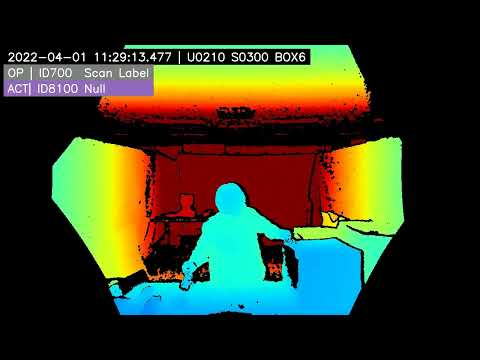

In [1]:
from IPython.display import YouTubeVideo
YouTubeVideo('KRG5zv3ueRQ', width=600, height=400)

## [3] Sample Programs

From here on, we will build a neural network that estimates 10 different work operations every second, using acceleration data collected by IMU sensors attached to the left wrists as input.
We want to focus on learning the basic ideas of modeling, so there are several codes required, but if there are no specific instructions, just run the code as it is.
If you wish to try more advanced experiments, such as data preprocessing or modifying the training method, we hope you will deepen your understanding in another tutorial.

- Input: acceleration signal collected from the left wrist at 30 Hz for 60 seconds (Shape of input Tensor: `(1800, 6)`)
- Output: Work operation labels every 1 second (Shape of Tensor: `(60, 10)`)
- Model: Neural Network (PyTorch)

![](../../../assets/img/tutorial/task.jpg)

### Model for Activity Recognition

In this section, we briefly summarize what perspectives should be taken to build an activity recognition model.
The implementation and parameters to consider are explained while running the sample below.

First, here are some examples of what to consider when dealing with multimodal time series data.

1. Temporal Dependencies
    1. range to be considered (1 sec? 10 seconds?) ... Set the range with reference to the duration of the activities to be recognized, etc.
    1. whether to consider only the forward temporal dependency or backword temporal dependency?　... When classifying "taps" and "double taps," it is necessary to consider both the past and the future in order to distinguish which is the first tap.
1. Modality
    1. sensor fusion (extract features for both hand movements at once? OR perform separate feature extraction for right and left wrist and then combine them?) ... Since the left and right hands can move independently, it may be more effective to consider them separately. 1.
    1. how to combine with other modalities (video, logs from IoT devices, etc.)

It is difficult to cover everything in this tutorial, so we will consider **temporal dependency**.

### Key Aspect to buld model for Operations in OpenPack Dataset

Basically the same as the above two items, but we will explain more specific part to OpenPack Dataset.

- The movements are mainly performed with the hands only. Therefore, there are many movements that are very similar in acceleration data alone.
    - e.g.) Arm movement: Assemble Box and Close Box
    - It is considered effective to estimate the activityt at the time of interest **using the previous and following work processes as a clue**.
- Activity order is basically fixed.
    - The order of activities is approximately fixed because the workflow is fixed.
    - The **actitity order can be a important hint** for prediction.
    - (Note) As the accuracy increases to a certain degree, misrecognition of out-of-normal order due to work errors becomes an issue.　In order to improve the accuracy, how to handle this part is important to improve accuracy.

![](../../../assets/img/tutorial/work_HAR_idea.jpg)

------
Let's move to implementation part.

## [4] Inialize Environment (Please execute only once)

### 4-1: Download Code and Install `openpack-torch` 

In [ ]:
# download sample codes
! cd /content && git clone https://github.com/open-pack/openpack-torch.git

In [ ]:
# install openpack-torch from source code
! cd /content/openpack-torch/ && pip install .

### 4-2: Download Dataset from Zenodo

NOTE: If you are running this notebook on colab, please mount your Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Dataset Directory: `/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets`

In [ ]:
# NOTE: If you have already downloaded the dataset, you can skip this cell.
! mkdir -p "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets"
! optk-download -d "/content/drive/MyDrive/Colab Notebooks/openpack/data/datasets" -s atr-qags,activity-1s

In [ ]:
! ln -s "/content/drive/MyDrive/Colab Notebooks/openpack/data/" "/content/data"

### 4-3: Import Modules

In [1]:
import os
import shutil
import logging
from pathlib import Path
from typing import Dict, Optional


import hydra
import numpy as np
import openpack_toolkit as optk
import openpack_torch as optorch
import pandas as pd
import pytorch_lightning as pl
import torch
from torch import nn
from scipy.special import softmax

import matplotlib.pyplot as plt
import seaborn as sns
from hydra import initialize_config_dir, compose
from omegaconf import DictConfig, OmegaConf

from openpack_toolkit import OPENPACK_OPERATIONS
from openpack_toolkit.codalab.operation_segmentation import (
    construct_submission_dict, eval_operation_segmentation_wrapper,
    make_submission_zipfile)

sns.set("notebook", "whitegrid")

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")


In [2]:
_ = optk.utils.notebook.setup_root_logger()
logger = logging.getLogger(__name__)

logger.debug("debug")
logger.info("info")
logger.warning("warning")

2022-10-05 22:07:11 | INFO | __main__ | info
2022-10-05 22:07:11 | WARNING | __main__ | warning


### 4-4: Load Config Files 

Loads default parameters. 
When modeling in deep learning, there are a large number of hyperparameters, and managing them is important for reproducibility and efficiency of experiments.
Various tools have been proposed to solve this problem. Here we use [hydra](https://hydra.cc/).

In [3]:
# Copy the sample config files
! cp -r /content/openpack-torch/examples/deep-conv-lstm/configs /content/

In [4]:
# Load parameters for the dataset.
optorch.configs.register_configs()

# Load paramters for models and training.
overrides = [
    "mode=train",
    "issue=I01-EXP1-V1-nb", # subdirectry for logging
    
    # -- debug --
    # If true, some training parameters (e.g., bach size, epochs) are switched to debug mode setting written in `train.debug.XXX`.
    "debug=false",
    
    # -- path.logdir.rootdir --
    # path to write training logs and resutls.
    # If you want to keep logs, please use Google Drive (i.e., `/content/drive/XXX` )
    "path.logdir.rootdir=/content/logs/${dataset.name}/${model.name}/${issue}"
    
    # "hydra/job_logging=custom",
    # "hydra/hydra_logging=disabled"
]

with hydra.initialize_config_dir(version_base=None, config_dir="/content/configs"):
    cfg = hydra.compose(
        config_name="deep-conv-lstm.yaml",
        overrides=overrides,
    )

# -- Target Acticity Class --
cfg.dataset.annotation.activity_sets = dict()

# -- Data Split --
# Change Train/Val/Test/Submission set to save training time. 
cfg.dataset.split = optk.configs.datasets.splits.PILOT_CHALLENGE_SPLIT

In [5]:
print(OmegaConf.to_yaml(cfg))

dataset:
  annotation:
    conf_type: ANNOT_FILE
    name: activity-1s
    version: ''
    path:
      dir: ${path.openpack.rootdir}/${user.name}/annotation/activity-1s/
      fname: ${session}.csv
    file_format: null
    classes: ???
    activity_sets: {}
  stream:
    schema: ImuConfig
    name: atr-acc-left-wrist
    description: null
    super_stream: atr-qags
    path:
      dir: ${path.openpack.rootdir}/${user.name}/atr/${device}
      fname: ${session}.csv
    file_format: null
    frame_rate: 30
    devices:
    - atr01
    acc: true
    gyro: false
    quat: false
  split:
    name: pilot-challenge
    train:
    - - U0102
      - S0100
    - - U0102
      - S0200
    - - U0102
      - S0300
    - - U0102
      - S0400
    - - U0102
      - S0500
    - - U0103
      - S0100
    - - U0103
      - S0200
    - - U0103
      - S0300
    - - U0103
      - S0400
    - - U0103
      - S0500
    - - U0105
      - S0100
    - - U0105
      - S0200
    - - U0105
      - S0300
    - - 

## [5] Build Model

### 5-1: Overview of Baseline Model (DeepConvLSTM)

In this tutorial, we will build a several variants of DeepConvLSTM ([Sensors 2016](https://www.mdpi.com/1424-8220/16/1/115)).
This model is used in many studies as a baseline method.
It is designed to consider both short-term and long-term dependencies by first extracting local features in the convolution layer and then extracting long-term dependencies in the LSTM layer.

Reference: [Deep Convolutional and LSTM Recurrent Neural Networks for Multimodal Wearable Activity Recognition (Sensors, 2016)](https://www.mdpi.com/1424-8220/16/1/115) 

### 5-2: Variants of DeepConvLSTM

Here, we prepared 3 variabts.

1. CNN Only
    1. Change the length of time to extract features by changing the size of the convolution filter.
    1. Change the number of convolutional layers.
1. DeepConvLSTM (Proposed in [Sensos 2016])
1. Bidiractional LSTM (Replace the normal LSTM layer with bidirectional LSTM layer.)


![](../../../assets/img/tutorial/dcl_architecture.jpg)

### 5-3: CNN Only (ver.1) 

This model uses only convolutional layers.
The range of time to extract features can be changed by changing (A) the kernel size and (B) the number of convolution layers.
Convolutional layers are defined as `Conv2d()` in PyTorch.


#### Experiment 1-A: Kernel Size (`ks`)

The sampling rate of the sensor is 30 Hz.
That is, if kernel size is set to `ks=30`, features can be extracted from a range of 1 second in a single convolution operation.
In our experiments, we will train models with the following values and compare the results.
Note that the duration of the OpenPack workflow varies depending on the workflow, but typically ranges from 2 to 15 seconds.


- `ks=5` (0.16sec; used in the paper)
- `ks=15` (0.5sec)
- `ks=30` (1.0sec)
- `ks=60` (2.0sec)

#### Experiment 1-B: Number of Convolutional Layers (`num_conv_layers`)

You can also extend the range of feature extraction by layering convolution layers.
Try the following values.

- `num_conv_layers = 1`
- `num_conv_layers = 4` (used in their paper)
- `num_conv_layers = 8`


#### Experiment 1-C: (Kernel Size) x (Number of Layers)

Both "kernel size" and "number of convolution layers" can change the extent to which features are extracted.
The combination of these two parameters is also very important.
For example, a small kernel size and a large number of layers can gradually capture long-term dependencies while capturing fine-grained features.
This approach has often been used in computer vision models.
Conversely, an approach with a large kernel size and a reduced number of layers can be more robust to local noise due to the larger convolutional range.
Experiment to see which approach is better.


![](../../../assets/img/tutorial/cnn_receptive_field.jpg)

In [6]:
class DeepConvLstmV1(nn.Module):
    """CNN Only
    """
    def __init__(self, in_ch: int = 3, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN  --
        # *** Edit Here ***
        # NOTE: Experiment 1-A: Kernel Size (NOTE: set odd number)
        ks = 5
        # NOTE: Experiment 1-B: # of convolutional layers (Default: 4)
        num_conv_layers = 4
        # ******************
        num_conv_filter = 64 # convolutional filters (Default: 64)
        
        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else num_conv_filter 
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, num_conv_filter, kernel_size=(ks, 1), padding=(ks//2, 0)),
                    nn.BatchNorm2d(num_conv_filter),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [3] Output --
        self.out8 = nn.Conv2d(
            num_conv_filter,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)
            
        # -- [3] Output --
        x = self.out8(x)
        return x


### 5-4: DeepConvLstm (ver.2)

This is the model architecture proposed in the paper, with an LSTM layer added to ver. 1.
The LSTM enables the model to extract long-term dependencies.

In [7]:
class DeepConvLstm(nn.Module):
    """Architecture proposed in the paper.
    """
    def __init__(self, in_ch: int = 3, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN --
        # *** Edit Here ***
        num_conv_layers = 4 # convolutional layers (Default: 4)
        num_conv_filter = 64 # convolutional filters (Default: 64)
        ks = 5 # kernel size, 
        # ******************
        
        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else 64
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, 64, kernel_size=(5, 1), padding=(2, 0)),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [2] LSTM --
        # *** Edit Here ***        
        hidden_units = 128 # number of hidden units for LSTM
        # ******************
        
        self.lstm6 = nn.LSTM(num_conv_filter, hidden_units, batch_first=True)
        self.lstm7 = nn.LSTM(hidden_units, hidden_units, batch_first=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)

        # -- [3] Output --
        self.out8 = nn.Conv2d(
            hidden_units,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)

        # -- [2] LSTM (!! Added !!) --
        # Reshape: (B, CH, 1, T) -> (B, T, CH)
        x = x.squeeze(3).transpose(1, 2)

        x, _ = self.lstm6(x)
        x = self.dropout6(x)
        x, _ = self.lstm7(x)
        x = self.dropout7(x)

        # Reshape: (B, T, CH) -> (B, CH, T, 1)
        x = x.transpose(1, 2).unsqueeze(3) 
        
        # -- [3] Output --
        x = self.out8(x)
        return x


### 5-5: DeepConvLstm (ver.3)

The LSTM layer in ver. 2 was replaced with a bi-directional LSTM layer to enable the extraction of backward as well as forward time dependence.
This change allows us to predict the activity of interest not only from the previous activity, but also from the next activity 

In [8]:
class DeepConvLstmV3(nn.Module):
    def __init__(self, in_ch: int = 3, num_classes: int = None):
        super().__init__()
        if num_classes is None:
            num_classes = len(OPENPACK_OPERATIONS)

        # -- [1] CNN --
        # *** Edit Here ***
        num_conv_layers = 4 # convolutional layers (Default: 4)
        num_conv_filter = 64 # convolutional filters (Default: 64)
        ks = 5 # kernel size, 
        # ******************
        
        blocks = []
        for i in range(num_conv_layers):
            in_ch_ = in_ch if i == 0 else 64
            blocks.append(
                nn.Sequential(
                    nn.Conv2d(in_ch_, 64, kernel_size=(5, 1), padding=(2, 0)),
                    nn.BatchNorm2d(64),
                    nn.ReLU(),
                )
            )
        self.conv_blocks = nn.ModuleList(blocks)

        # -- [2] LSTM --
        # *** Edit Here ***        
        hidden_units = 128 # number of hidden units for Bi-LSTM
        # ******************
        
        # NOTE: enable ``bidirectional``
        self.lstm6 = nn.LSTM(num_conv_filter, hidden_units, batch_first=True, bidirectional=True)
        self.lstm7 = nn.LSTM(hidden_units*2, hidden_units, batch_first=True,  bidirectional=True)
        self.dropout6 = nn.Dropout(p=0.5)
        self.dropout7 = nn.Dropout(p=0.5)

        # -- [3] Output --
        self.out8 = nn.Conv2d(
            hidden_units * 2,
            num_classes,
            1,
            stride=1,
            padding=0,
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Args:
            x (torch.Tensor): shape = (B, CH, T, 1)
        Returns:
            torch.Tensor: shape = (B, N_CLASSES, T, 1)
        """
        # -- [1] Conv --
        for block in self.conv_blocks:
            x = block(x)

        # -- [2] LSTM --
        # Reshape: (B, CH, 1, T) -> (B, T, CH)
        x = x.squeeze(3).transpose(1, 2)

        x, _ = self.lstm6(x)
        x = self.dropout6(x)
        x, _ = self.lstm7(x)
        x = self.dropout7(x)

        # Reshape: (B, T, CH) -> (B, CH, T, 1)
        x = x.transpose(1, 2).unsqueeze(3) 
        
        # -- [3] Output --
        x = self.out8(x)
        return x


## [6] Training

### 6-1: DataModule

Initializes the module responsible for loading and preprocessing the dataset.
Run the this block as-is without editing.

In [9]:
class OpenPackImuDataModule(optorch.data.OpenPackBaseDataModule):
    dataset_class = optorch.data.datasets.OpenPackImu

    def get_kwargs_for_datasets(self, stage: Optional[str] = None) -> Dict:
        kwargs = {
            "window": self.cfg.train.window,
            "debug": self.cfg.debug,
        }
        return kwargs

### 6-2: Lightning Module (EDIT HERE !!)

This module is responsible for training, testing.
Please uncomment the model you want to try in `init_model` and run this block after the above DataModulle cell.


In [10]:
class MyModelLM(optorch.lightning.BaseLightningModule):

    def init_model(self, cfg: DictConfig) -> torch.nn.Module:
        """ Initalize your model
        
        Generate an instance of the model you defined in the above.
        Uncomment the target model.
        """
        # !! Edit Here !!
        # NOTE: Please select the model you want to use!
        model = DeepConvLstmV1()
        # model = DeepConvLstm()
        # model = DeepConvLstmV3()
        return model
    
    
    def init_criterion(self, cfg: DictConfig):
        """Initialize loss function
        """
        ignore_cls = [(i, c) for i, c in enumerate(cfg.dataset.classes.classes) if c.is_ignore]
        
        criterion = torch.nn.CrossEntropyLoss(
            ignore_index=ignore_cls[-1][0]
        )
        return criterion

    def training_step(self, batch: Dict, batch_idx: int) -> Dict:
        """Definition of training loop. Get mini-batch and return loss.
        """
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        y_hat = self(x).squeeze(3)

        loss = self.criterion(y_hat, t)
        acc = self.calc_accuracy(y_hat, t)
        return {"loss": loss, "acc": acc}

    def test_step(self, batch: Dict, batch_idx: int) -> Dict:
        """Definition of inference step. Get mini-batch and return model outputs.
        """
        x = batch["x"].to(device=self.device, dtype=torch.float)
        t = batch["t"].to(device=self.device, dtype=torch.long)
        ts_unix = batch["ts"]

        y_hat = self(x).squeeze(3)

        outputs = dict(t=t, y=y_hat, unixtime=ts_unix)
        return outputs


In [11]:
def test(cfg: DictConfig, datamodule: pl.LightningDataModule, trainer: pl.Trainer):
    """ Evaluate your model with test data """
    datamodule.setup("test")
    dataloaders = datamodule.test_dataloader()
    split = cfg.dataset.split.test

    # inference on the test data
    outputs = dict()
    for i, dataloader in enumerate(dataloaders):
        user, session = split[i]
        logger.info(f"test on {user}-{session}")

        trainer.test(plmodel, dataloader)

        # save model outputs
        pred_dir = Path(
            cfg.path.logdir.predict.format(user=user, session=session)
        )
        pred_dir.mkdir(parents=True, exist_ok=True)

        for key, arr in plmodel.test_results.items():
            path = Path(pred_dir, f"{key}.npy")
            np.save(path, arr)
            logger.info(f"save {key}[shape={arr.shape}] to {path}")

        outputs[f"{user}-{session}"] = {
            "t_idx": plmodel.test_results.get("t"),
            "y": plmodel.test_results.get("y"),
            "unixtime": plmodel.test_results.get("unixtime"),
        }
    
    # calculate metrics
    df_summary = eval_operation_segmentation_wrapper(
        cfg, outputs, OPENPACK_OPERATIONS)
       
    return outputs, df_summary


def plot_timeline(samples, t_idx, y_softmax, title_prefix=""):
    """visualize model outputs as heatmap """
    fig, ax0 = plt.subplots(1, 1, figsize=(20, 4))

    prob = y_softmax[slice(*samples)].transpose(1, 0, 2).reshape(11, -1)
    gt = t_idx[slice(*samples)].ravel()
    pred = prob.argmax(axis=0)
    
    print(f"prob={prob.shape} pred={pred.shape}, gt={gt.shape}")
    seq_len = prob.shape[1]

    # -- Prob --
    sns.heatmap(
        prob,
        vmin=0, vmax=1.0, cmap="viridis", cbar=False,
        ax=ax0
    )

    # -- Ground Truth --
    x = np.arange(seq_len)
    ax0.plot(
        x, gt + 0.5, label="ground truth",
        linewidth=5, color="C3", 
    )

    # -- Style --
    ax0.invert_yaxis()
    xticks = np.arange(0, seq_len, 30 * 30)
    xticks_minor = np.arange(0, seq_len, 30 * 10)
    ax0.set_xticks(xticks)
    ax0.set_xticklabels(xticks // 30 + samples[0] * 60, rotation=0)
    ax0.set_xticks(xticks_minor, minor=True)

    ax0.set_yticks(np.arange(11) + 0.5)
    ax0.set_yticklabels(np.arange(11), rotation=0)
    
    
    ax0.set_xlabel("Time [s]", fontsize="large", fontweight="bold")
    ax0.set_ylabel("Class Index", fontsize="large", fontweight="bold")
    ax0.set_title(f"{title_prefix} | {samples[0]}min ~ {samples[1]}min", fontsize="xx-large", fontweight="bold")
    ax0.grid(True, which="minor", linestyle=":")
    ax0.legend(loc="upper right")

    fig.tight_layout()
    return fig


### 6-3: Initialize Model, Datasets, Trainer

In [12]:
# Reset random seed for better reproducibility
optorch.utils.reset_seed(seed=0)

device = torch.device("cuda")
logdir = Path(cfg.path.logdir.rootdir)
logger.debug(f"logdir = {logdir}")

datamodule = OpenPackImuDataModule(cfg) # (1) dataset
plmodel = MyModelLM(cfg).to(dtype=torch.float, device=device) # (2) model

2022-10-05 22:07:24 | INFO | openpack_torch.utils.random | Reset Seeds: python=0, numpy=0, Pytorch (cpu=0, cuda=0)


In [13]:
# NOTE: set the training epochs
num_epoch = 50 

checkpoint_callback = pl.callbacks.ModelCheckpoint(
    save_top_k=0,
    save_last=True,
    monitor=None,
)

trainer = pl.Trainer(
    gpus=[0],
    max_epochs=num_epoch,
    logger=False,  # disable logging module
    default_root_dir=logdir,
    enable_progress_bar=False,  # disable progress bar
    enable_checkpointing=True,
    callbacks=[checkpoint_callback],
)
logger.debug(f"logdir = {logdir}")

/opt/conda/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/accelerator_connector.py:446: LightningDeprecationWarning: Setting `Trainer(gpus=[0])` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=[0])` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
plmodel

MyModelLM(
  (net): DeepConvLstmV1(
    (conv_blocks): ModuleList(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (3): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 1), stride=(1, 1), padding=(2, 0))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
    )
    (out8): Conv2d(64, 11, kernel_si

### 6-4: Training

#### 6-4-1: Check Model Outputs before Training

In [15]:
outputs, df_summary = test(cfg, datamodule, trainer)

2022-10-05 22:07:26 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-10-05 22:07:26 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-10-05 22:07:26 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-10-05 22:07:26 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-10-05 22:07:26 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-10-05 22:07:26 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f87bfb69f40>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7f87b0065d30>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f87b0090700>}
2022-10-05 22:07:26 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2022-10-05 22:07:26 | INFO | __main__ | test on U0106-S0100
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
2022-10-05 22:07:27 | INFO | __main__ | 

In [16]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
36,avg/macro,-1,0.053161,0.101657,0.030255,None,all
37,avg/weighted,-1,0.047471,0.157172,0.044236,None,all
38,Picking,100,0.000000,0.000000,0.000000,552,all
39,Relocate Item Label,200,0.156606,1.000000,0.270803,921,all
40,Assemble Box,300,0.000000,0.000000,0.000000,971,all
41,Insert Items,400,0.000000,0.000000,0.000000,489,all
42,Close Box,500,0.000000,0.000000,0.000000,645,all
43,Attach Box Label,600,0.000000,0.000000,0.000000,328,all
44,Scan Label,700,0.000000,0.000000,0.000000,680,all
45,Attach Shipping Label,800,0.000000,0.000000,0.000000,462,all


In [17]:
# Segment key to visualize
key = "U0106-S0500"

# Get predictions
unixtimes = outputs[key]["unixtime"] 
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(18, 1800), t_idx=(18, 1800), y=(18, 11, 1800), y_softmax=(18, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


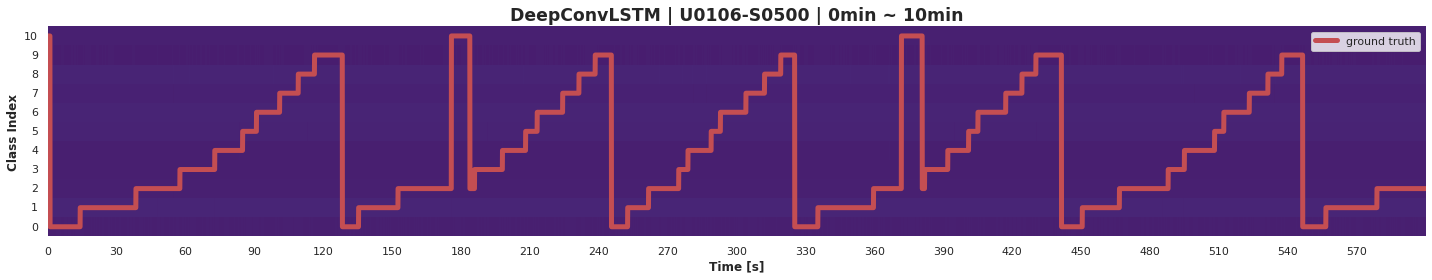

In [18]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {key}")
fig.show()

How to see the heatmap:

- Red line: ground truth
- Background: Prediction probabilities (high probabilities are shown in yellow. All classes have a low probability of being correct because they are random before training).
- Horizontal axis: time
- Vertical axis: Index of the action class (1 = Picking[ID100], 2=Relocate Label[ID=200], ...)

Please remember these results before training and compare them with the results after training.

#### 6-4-2: Training

In [19]:
logger.info(f"Start training for {num_epoch} epochs.")
trainer.fit(plmodel, datamodule)
logger.info("Finish training!")

2022-10-05 22:07:28 | INFO | __main__ | Start training for 50 epochs.
2022-10-05 22:07:29 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-10-05 22:07:29 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-10-05 22:07:29 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-10-05 22:07:29 | INFO | openpack_torch.data.datamodule | dataset[train]: OpenPackImu(index=533, num_sequence=15, submission=False)
2022-10-05 22:07:29 | INFO | openpack_torch.data.datamodule | dataset[val]: {'U0106-S0200': <openpack_torch.data.datasets.OpenPackImu object at 0x7f8737d27640>, 'U0106-S0400': <openpack_torch.data.datasets.OpenPackImu object at 0x7f8737d21f40>}
2022-10-05 22:07:29 | INFO | openpack_torch.data.datamodule | dataset[test]: None
2022-10-05 22:07:29 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type             | Params
------------------

#### 6-4-5: Plot Training Curve

To verify that the model is training well, plot the change in loss per epoch.
Observe that the loss gradually decreases as the epoch progresses.

In [20]:
df = pd.concat([
    pd.DataFrame(plmodel.log_dict["train"]),
    pd.DataFrame(plmodel.log_dict["val"]),
],axis=1,)
df.index.name = "epoch"

In [21]:
df.head()

,train/loss,train/acc,val/loss,val/acc
epoch,,,,
0,2.422131,0.141797,2.395301,0.152833
1,2.196349,0.292191,2.382857,0.180393
2,2.082557,0.346801,2.260986,0.280662
3,2.016069,0.363855,2.161593,0.314285
4,1.965155,0.374251,2.114071,0.320878


Training Log

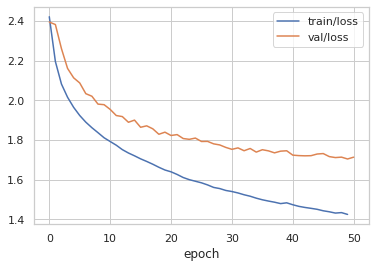

In [22]:
df[["train/loss", "val/loss"]].plot()
plt.show()

Test Log

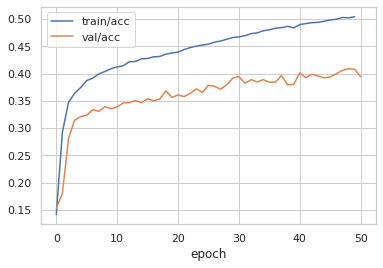

In [23]:
df[["train/acc", "val/acc"]].plot()
plt.show()

### 6-5: Evaluation

In [24]:
# Evaluate on test set
outputs, df_summary = test(cfg, datamodule, trainer)

2022-10-05 22:07:57 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-10-05 22:07:57 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-10-05 22:07:57 | WARNING | openpack_torch.data.datasets | No preprocessing is applied.
2022-10-05 22:07:57 | INFO | openpack_torch.data.datamodule | dataset[train]: None
2022-10-05 22:07:57 | INFO | openpack_torch.data.datamodule | dataset[val]: None
2022-10-05 22:07:57 | INFO | openpack_torch.data.datamodule | dataset[test]: {'U0106-S0100': <openpack_torch.data.datasets.OpenPackImu object at 0x7f8737ac52b0>, 'U0106-S0300': <openpack_torch.data.datasets.OpenPackImu object at 0x7f8737ae8c40>, 'U0106-S0500': <openpack_torch.data.datasets.OpenPackImu object at 0x7f8737a926d0>}
2022-10-05 22:07:57 | INFO | openpack_torch.data.datamodule | dataset[submission]: None
2022-10-05 22:07:57 | INFO | __main__ | test on U0106-S0100
2022-10-05 22:07:57 | WARNING | openpack_torch.data.datasets | No preprocessing is

#### Metrics:

- Precision
- Recall
- F1-measure (metrics used in OpenPack Challenge 2022)


In [25]:
df_summary[df_summary["key"]=="all"]

,name,id,precision,recall,f1,support,key
36,avg/macro,-1,0.339008,0.342397,0.329010,None,all
37,avg/weighted,-1,0.360771,0.378942,0.356682,None,all
38,Picking,100,0.265537,0.255435,0.260388,552,all
39,Relocate Item Label,200,0.395655,0.652552,0.492623,921,all
40,Assemble Box,300,0.466208,0.419156,0.441432,971,all
41,Insert Items,400,0.325217,0.382413,0.351504,489,all
42,Close Box,500,0.345821,0.186047,0.241935,645,all
43,Attach Box Label,600,0.000000,0.000000,0.000000,328,all
44,Scan Label,700,0.346004,0.522059,0.416178,680,all
45,Attach Shipping Label,800,0.403974,0.264069,0.319372,462,all


#### Visualization

In [26]:
# Segment key to visualize
key = "U0106-S0500"

# Get predictions
unixtimes = outputs[key]["unixtime"] 
t_idx = outputs[key]["t_idx"]
y = outputs[key]["y"]
y_softmax = softmax(y, axis=1)
print(f"unixtimes={unixtimes.shape}, t_idx={t_idx.shape}, y={y.shape}, y_softmax={y_softmax.shape}")

unixtimes=(18, 1800), t_idx=(18, 1800), y=(18, 11, 1800), y_softmax=(18, 11, 1800)


prob=(11, 18000) pred=(18000,), gt=(18000,)


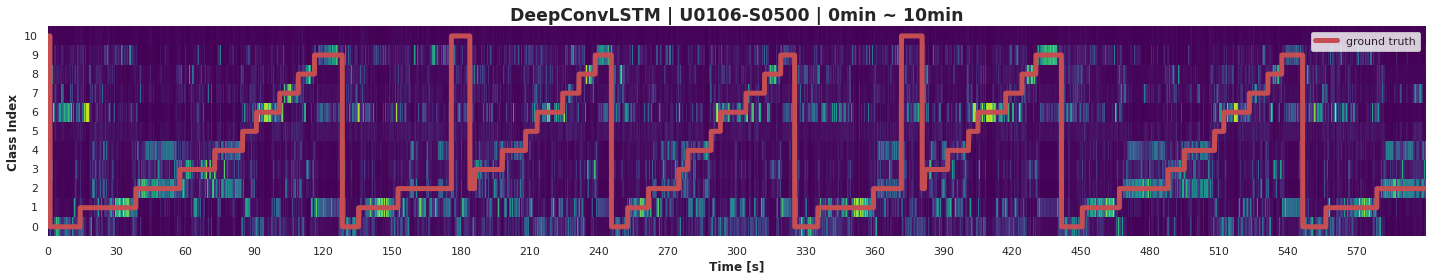

In [27]:
samples = (0, 10)

fig = plot_timeline(samples, t_idx, y_softmax, title_prefix=f"{cfg.model.name} | {key}")
fig.show()

How does the output compare to the pre-study diagram?
You can see that the area around the red correct answer label has turned yellow. With some modeling, the score can be increased to nearly 90%. Try different models and parameters.